# Vegetables Classification

## Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout ,GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix,classification_report
import os, shutil
import warnings
warnings.filterwarnings('ignore')

## Download Dataset

In [ ]:
!pip install -q opendatasets

import opendatasets as od

od.download('https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: afrizameidioandhana
Your Kaggle Key: ··········


100%|██████████| 534M/534M [00:06<00:00, 83.3MB/s]


In [ ]:
pip install split-folders

  Using cached split_folders-0.5.1-py3-none-any.whl (8.4 kB)


In [ ]:
import splitfolders
splitfolders.ratio('/content/vegetable-image-dataset/Vegetable Images/train', output="dataset", seed=1337, ratio=(.8, 0.2))

Copying files: 15000 files [00:04, 3175.76 files/s]


In [ ]:
train_data = "/content/dataset/train"
validation_data = "/content/dataset/val"

## Augmentasi Gambar

In [ ]:
train_gen = ImageDataGenerator( featurewise_center=False,
                                samplewise_center=False,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=False,
                                zca_whitening=False,
                                rotation_range=10,
                                zoom_range = 0.1,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=False,
                              )

train_image_generator = train_gen.flow_from_directory(
                                            train_data,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')


val_gen = ImageDataGenerator()
val_image_generator = val_gen.flow_from_directory(
                                            validation_data,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

Found 12000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


## CNN Model

In [ ]:
model = tf.keras.models.Sequential([
    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(filters = 96, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Flatten(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(512,activation='relu'),
    Dense(15, activation = "softmax"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        153696    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 96)        0

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics='accuracy')

## Callback

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("accuracy > 92% skala data")
      self.model.stop_training = True
callbacks = myCallback()

early_stopping = keras.callbacks.EarlyStopping(patience=3,monitor='val_loss',restore_best_weights=True)

## Model Train

In [22]:
history = model.fit(train_image_generator,
                 epochs=50,
                 verbose=1,
                 validation_data=val_image_generator,
                 steps_per_epoch = 15000//32,
                 validation_steps = 3000//32,
                  callbacks=[callbacks],
                 workers=4
                )

Epoch 1/50
468/468 [==============================] - 1161s 2s/step - loss: 0.3175 - accuracy: 0.9026 - val_loss: 0.4385 - val_accuracy: 0.8606
Epoch 2/50
468/468 [==============================] - 1167s 2s/step - loss: 0.2498 - accuracy: 0.9219 - val_loss: 0.2935 - val_accuracy: 0.9126
Epoch 3/50
468/468 [==============================] - 1154s 2s/step - loss: 0.2024 - accuracy: 0.9387 - val_loss: 0.1826 - val_accuracy: 0.9446


## Evaluasi Model

In [29]:
model.evaluate(train_image_generator)

375/375 [==============================] - 297s 792ms/step - loss: 0.1326 - accuracy: 0.9592


[0.1325654238462448, 0.9591666460037231]

In [30]:
model.evaluate(val_image_generator)

94/94 [==============================] - 61s 651ms/step - loss: 0.1823 - accuracy: 0.9443


[0.18225297331809998, 0.9443333148956299]

<Axes: >

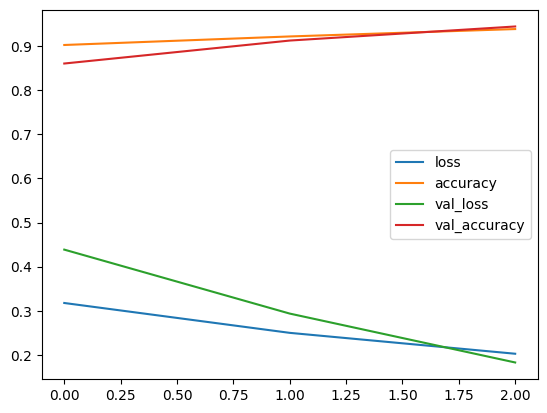

In [23]:
pd.DataFrame(history.history).plot()

## Menyimpan Model

In [24]:
import pathlib
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi vegetable.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegetable.tflite')
tflite_model_file.write_bytes(tflite_model)

18044800

In [25]:
%cd /content

/content


In [26]:
!zip -r veg_model.zip saved_model/

updating: saved_model/ (stored 0%)
updating: saved_model/saved_model.pb (deflated 87%)
updating: saved_model/variables/ (stored 0%)
updating: saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
updating: saved_model/variables/variables.index (deflated 66%)
updating: saved_model/assets/ (stored 0%)
updating: saved_model/fingerprint.pb (stored 0%)


In [28]:
from google.colab import files
files.download('veg_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>